# Short Rate Modelling with the Vasicek Model

I have often been intimiated by some of the more 'quantsy' lingo like modelling, calibration etc... and thought it was about time to break the spell. We'll take a look at the Vasicek model - a rather simplistic way to model interest rates.

## Interest rates in the real world

If you wish to lend a friend $100 over the course of 3 months, you (may) expect to get some interest back. The interest rate will depend on a number of factors but a common proxy for what this rate should be is called [LIBOR](https://en.wikipedia.org/wiki/Libor) (assuming your friend is as trustworthy as a large, established bank - or more). That rate changes every day and you can have a look at how it has evolved over time [here](https://fred.stlouisfed.org/graph/?g=dE0U).

It is worth noting the rate quoted is annualised - even though the rate might be 2% that is over the course of a full year, over the course of 3 months this would be $\frac{3}{12}2\% = 0.5\%$.

Let's graph the rate for the first quarter of 2017.


In [11]:
import requests
url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?chart_type=line&recession_bars=on&log_scales=&bgcolor=%23e1e9f0&graph_bgcolor=%23ffffff&fo=Open+Sans&ts=12&tts=12&txtcolor=%23444444&show_legend=yes&show_axis_titles=yes&drp=0&cosd=2016-12-30&coed=2017-03-30&height=450&stacking=&range=Custom&mode=fred&id=USD3MTD156N&transformation=lin&nd=1986-01-02&ost=-99999&oet=99999&lsv=&lev=&mma=0&fml=a&fgst=lin&fgsnd=2009-06-01&fq=Daily&fam=avg&vintage_date=&revision_date=&line_color=%234572a7&line_style=solid&lw=2&scale=left&mark_type=none&mw=2&width=1168'
o = requests.get(url)
# NB we separate this from the cell below as we don't always want to re-fetch the data when changing the way the graph is displayed

        date    usd3m
0 2016-12-30  0.99789
1 2017-01-02      NaN
2 2017-01-03  0.99872
3 2017-01-04  1.00511
4 2017-01-05  1.00928


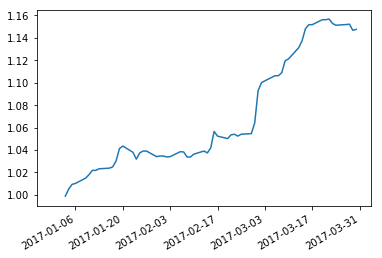

In [34]:
import io
import pandas as pd
df = pd.read_csv(io.StringIO(o.text)) # read_csv expects a file-like object
df = df.rename(columns={'DATE': 'date', 'USD3MTD156N': 'usd3m'})
df['usd3m'] = pd.to_numeric(df.usd3m, errors='coerce')
df['date'] = df.date.astype('datetime64')
print(df.head())

%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)
fig.autofmt_xdate() # to orientate the dates on the X axis properly
plt.plot(df.date,df.usd3m)


## The Vasicek Model

The Vasicek model is stochastic - which is a fancy word to say it is somewhat random. The function $y=x^2$ for instance is deterministic - if you plug in $x=2$ then $y=4$ - every day of the week. With a stochastic model you can't quite say that - they usually rely on some probability distribution, meaning the outcome is subject to randomness. It's worth noting it's not totally random - that randomness is usually well defined, like a sample from a normal distribution.

This particular model defines the partial derivative of the interest rate function with respect to time as:

$dr(t)=k(\theta-r(t))dt +  \sigma dW(t)$

The Vasicek model has 3 parameters - $k$, which represents the speed at which we revert to the mean, $theta$, the mean interest rate we will eventually revert to and $sigma$ - which represents the (random) degree of variation. $W(t)$ is a random Wiener process (also known as standrd Brownian motion).

### Simulating interest rates over time

If you recall derivatives from first principles, that small change ($dr(t)$) is essentially the difference between $r(t+h)$ and $r(t)$ as $h\to\infty$. In other words, given a small enough $h$ this tells us what the *next* value is going to be - so $r_{t+1} = r_t + dr(t)$. We can use this to generate subsequent observations:

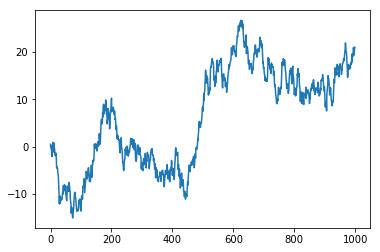

In [71]:
import numpy

numpy.random.seed(20100101)

def gen_vasicek_path(r0, k, theta, sigma, time_period=1, num_steps=100):
    '''
        r0 is the starting rate
        k is the speed at which we revert to the mean
        theta is the long-term average rate (mean)
        sigma is the degree of variation
    '''
    dt = time_period/float(num_steps)    
    steps = [(0,r0)]
    for i in range(num_steps):
        _, prev_rt = steps[-1]
        dr = k*(theta-prev_rt)*dt + sigma*numpy.random.normal()
        steps.append((i, prev_rt + dr))
    return steps

steps = gen_vasicek_path(0.5, 1,2,1,num_steps=1000)
plt.plot([idx for idx, _ in steps], [rt for _,rt in steps])

The fact that the shape seems to more or less reflect the actual data is arbitrary - if you change the seed you'll get something totally different.

You can play around with the parameters, including the seed, to generate a whole host of paths. For instance if you wanted to model a fast regression to the mean, you could bump $k$ and get something like:

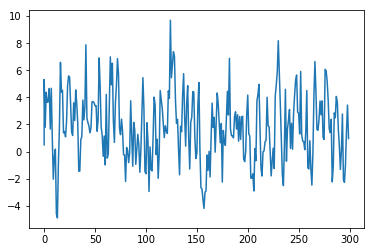

In [99]:
steps = gen_vasicek_path(0.5,k=100, theta=2, sigma=2, time_period=1, num_steps=300)
plt.plot([idx for idx, _ in steps], [rt for _,rt in steps])

### Fitting the model (a.k.a calibration)

The closed form (analytical) solution to this equation is as follows, for $0\leq s \leq t$:

$r(t) = r(s)e^{-k(t-s)}+\theta(1-e^{-k(t-s)}) + \sigma \int_{s}^{t}e^{-k(t-u)}dW(u)$

(I won't even attempt to derive this here, and [this page](http://planetmath.org/analyticsolutiontoornsteinuhlenbecksde) shows how it is done step by step).

In other words, it gives us a (linear) relationship between $r_{t}$ and $r_s$. Rewriting this more generically:

$r(t+1) = \alpha r(t) + \beta + \epsilon$

Where $\alpha=e^{-k(t-s)}$, $\beta=theta(1-e^{-k(t-s)})$ and $\epsilon=\sigma\sqrt{\frac{1}{2k}(1-e^{-2kt})}N(0,1)$. The error term might look a little confusing but remember that $W(t+1) - W(t) \sim N(0,1)$. On top of that the variance of $r(t)$ is derived to be $Var[r(t)] = \frac{\sigma^2}{2k}(1-e^{-2kt})$. It's still a random quantity but one which we can quantify.

With this form we are ready to use linear regression to estimate $\alpha$ and $\beta$ for our data covering Q1 2017, which will provide us with the best (biased?) estimates in the least square sense.


LinregressResult(slope=0.99841852037268641, intercept=0.0040641876862235193, rvalue=0.99428804582480967, pvalue=5.4371089131559259e-61, stderr=0.013722138336895404)


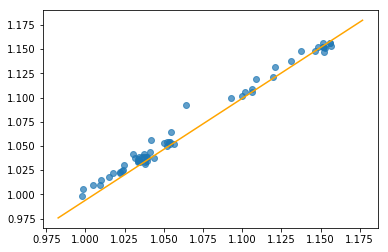

In [78]:
from scipy.stats import linregress
df.dropna(inplace=True) # we, sadly, have some NaNs in our data
res = linregress(df.usd3m[:-1], df.usd3m[1:])
plt.scatter(df.usd3m[:-1], df.usd3m[1:], alpha=0.7)
print(res)
xmin, xmax, ymin, ymax = plt.axis()
plt.plot([res.slope*xmin+res.intercept,res.slope*xmax+res.intercept],[ymin,ymax], c='orange')

We have $\alpha = 0.99842$ and $\beta = 0.0041$. We can rewrite each in terms of the original parameters in Viseck's model - namely:

$k = -\ln \alpha$, $\theta=\frac{\beta}{1-\alpha}$ and $\sigma=sd(\epsilon)\sqrt{\frac{-2\ln \alpha}{1-\alpha^2}}$

Substituting, we get:

In [64]:
a, b, stderr = res.slope, res.intercept, res.stderr
k = -numpy.log(a)
theta = b / (1-a)
sigma = stderr*numpy.sqrt(-2*numpy.log(a)/(1-a**2))
k, theta, sigma

(0.0015827314862530879, 2.5698640792023584, 0.013732998998234602)

We have now fitted our Viseck model to our real-life data - and can now generate paths which would reflect the data accorindgly:

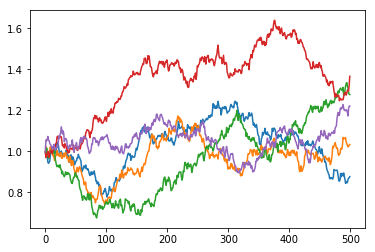

In [89]:
num_steps = 500
r0 = df.usd3m.ix[0]
num_samples = 5
numpy.random.seed(19991220)
for _ in range(num_samples):
    steps = gen_vasicek_path(r0, k, theta, sigma, time_period=90, num_steps=num_steps)
    plt.plot([idx for idx, _ in steps], [rt for _,rt in steps])


## Conclusion

That's a model and its calibration *done*. The maths is a little daunting and some of the results currently require a Leap Of Faith (LOF, as one of my maths lecturers would say when he didn't want to go through a whole proof).

There are still things I can look into - like how accurately does this model represent the data - though that's a great starting point.